# ACCESS Cloud processing - GUNW Product Count

In [2]:
%matplotlib widget
import datetime
import time
import requests
import progressbar
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
from ipywidgets import widgets, interact

session = requests.Session()

def get_count_of_products_since_date(start_date):
    search_parameters = {
        'provider': 'ASF',
        'page_size': 0,
        'collection_concept_id': 'C1595422627-ASF',
        'updated_since': start_date.isoformat(timespec='seconds'),
    }
    results = session.get('https://cmr.earthdata.nasa.gov/search/granules.umm_json', params=search_parameters)
    return results.json()['hits']

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield end_date - datetime.timedelta(n), n
        
start_date = datetime.datetime(year=2019, month=6, day=7, tzinfo=datetime.timezone.utc)
total_count = get_count_of_products_since_date(start_date)
print('Total count: {} products, since {}'.format(total_count, str(start_date.date())))

Total count: 665720 products, since 2019-06-07


## Get count per day

In [3]:
#get count per day 
end_date = datetime.datetime.now(tz=datetime.timezone.utc)
count_txt = 'asf_count.csv'

if (Path.cwd()/count_txt).is_file():
    df = pd.read_csv(count_txt)
    df['date'] = pd.to_datetime(df['date'])
    start_date = df['date'][0]
else:
    start_date = datetime.datetime(year=2019, month=6, day=7, tzinfo=datetime.timezone.utc)
    df = pd.DataFrame(columns=['date', 'count'])

ndays = (end_date - start_date).days

with progressbar.ProgressBar(max_value=ndays) as bar:
    for date, n in daterange(start_date, end_date):
        count = total_count - get_count_of_products_since_date(date)
        temp_df = pd.DataFrame({'date': [date], 'count': [count]})
        df = pd.concat([df, temp_df], ignore_index=True)
        bar.update(n)
        
## Save result to csv
df['date'] = pd.to_datetime(df['date']) if not df['date'].dtype == 'datetime' else print('df is in correct format')
df.to_csv('asf_count.csv')

100% (24 of 24) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


## Plotting

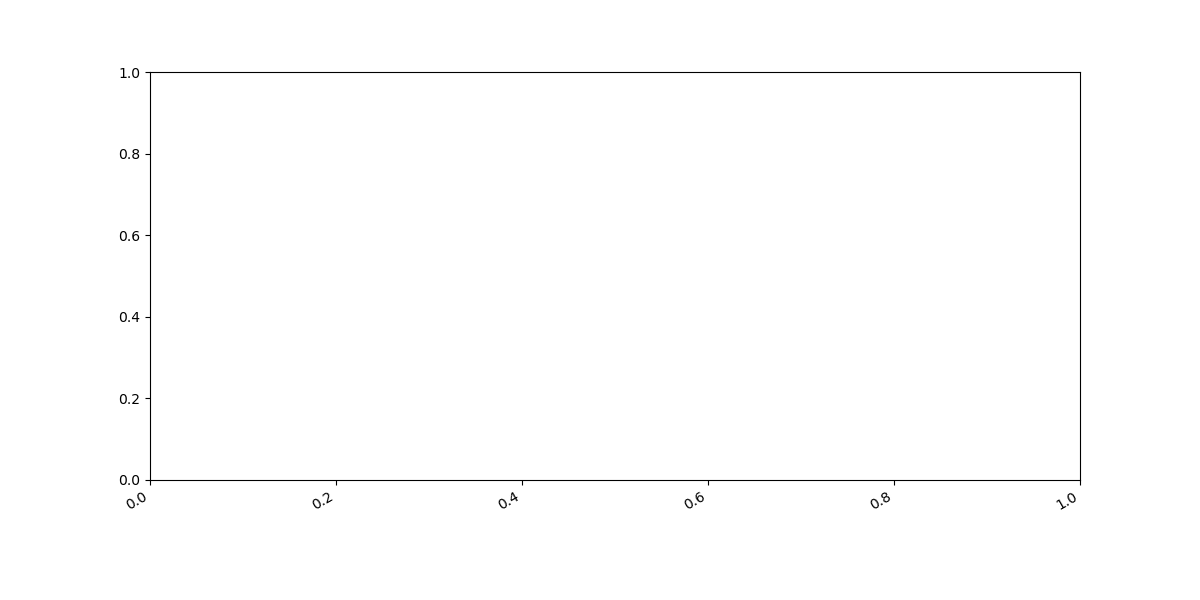

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 1134), layout=Layout(width='700px'),…

In [56]:
#### PLOT THE COUNT
def update(date_range):
    mask = (df['date'] > date_range[0]) & (df['date'] <= date_range[1])
    plt.cla()

    line, = ax.plot([min(df['date'][mask]), max(df['date'][mask])], 
                    [max(df['count'][mask]) - min(df['count'][mask]), max(df['count'][mask]) - min(df['count'][mask])],
                    color='red')
    data = ax.bar(df['date'][mask], 
                  df['count'][mask] - min(df['count'][mask]),
                  width=1)
    
    date_range_txt = df[mask].date.min().strftime('%d/%b/%Y') + ' - ' + df[mask].date.max().strftime('%d/%b/%Y')
    txt1 = 'Count: {}'.format(max(df['count'][mask]) - min(df['count'][mask]))
    txt2 = 'GUNW Count \n {}'.format(date_range_txt)  
    text = plt.text(0.05,0.95, txt1,fontsize=14,transform=ax.transAxes, color='red')
    
    print('Date range: ', date_range_txt)
    print('Count: ', max(df['count'][mask]) - min(df['count'][mask]))
    
    plt.grid()
    ax.set_title(txt2)
    ax.set_xlim([min(df['date'][mask]), max(df['date'][mask])])
    ax.set_ylim([min(df['count'][mask]) - min(df['count'][mask]), 
                (max(df['count'][mask]) - min(df['count'][mask])) + (max(df['count'][mask]) - min(df['count'][mask]))*0.08])
    ax.set_ylabel('Count #')
    ax.set_xlabel('Date')
    
    figure.canvas.draw()
    figure.canvas.flush_events()
  
## Sort it
df = df.sort_values(by=['date'])
options = [(date.strftime('%d/%b/%Y'), date) for date in df['date']]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '700px'}
)

figure, ax = plt.subplots(figsize=(12,6))
plt.gcf().autofmt_xdate()
plt.show()

widgets.interact(
    update,
    date_range=selection_range_slider
);